## Assignment 4: Obsevational Studies and Applied ML

### Deadline
November 21st,11:59PM

### Important notes

Make sure you push on GitHub your notebook with all the cells already evaluated. Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you implemented. Back up any hypotheses and claims with data, since this is an important aspect of the course. Please write all your comments in English, and use meaningful variable names in your code. Your repo should have a single notebook (plus the data files necessary) in the master branch. If there are multiple notebooks present, we will not grade anything.

Use this legendary link to create your repository: [link](https://classroom.github.com/g/YXtsr0QK)

In [52]:
# Put your imports here
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from scipy import stats as st
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import RidgeCV
import sklearn.utils as sk
import sklearn.linear_model as sk_lm
import sklearn.metrics as sk_m
import sklearn.ensemble as sk_ens


import matplotlib.ticker as mtick

from IPython.display import display_html

%matplotlib inline

In [7]:
data_folder = './data/'

## Task 1: Boosting the economy by incentivizing self-employment

Assume the biggest priority of the local government in 2018 is to increase per-capita income. To do so, the officials plan to adopt a strategy for incentivizing self-employment through a series of campaigns, educational programs, and dedicated funds.

Since it is unethical and impossible in this setting to run a controlled experiment involving citizens (e.g., fire employees and force them to self-employ), the officials have asked you, the data scientist, to establish the effect of self-employment on the economy, relying on observational data.

**A)** You will be working with the full US 2015 census dataset (acs2015_county_data.csv, available at https://www.kaggle.com/muonneutrino/us-census-demographic-data#acs2015_county_data.csv). Using suitable methods, determine and quantify the dependency between the percentage of self-employed citizens and per capita income across all 3,212 US counties. Do citizens in counties that have a higher percentage of self-employed people earn more per capita?

**B)** The pilot program will involve all counties within a limited set of three US states. Set A includes Wisconsin, Tennessee, and  Minnesota. Quantify the dependency of per-capita income on self-employment rates across all the counties in set A.

**C)** In which state within set A is the observed effect of self-employment on per-capita income the strongest?

**D)** Set B includes New Jersey, Kansas, and Rhode Island. Repeat the analysis from steps B and C above, but now for set B. In which of the two sets A and B (if any) would you recommend incentivizing self-employment? Explain your reasoning.

Hint: It is useful to add a notion of confidence to your results and explore the data visually. You are allowed to use the SciPy library.

### Task 1: Answer to Section A)


In [8]:
# Loading data
data_name = 'acs2015_county_data'
df_county = pd.read_csv(data_folder + data_name + '.csv')

# Displaying the data
pd.set_option('display.max_columns', 40)
display(df_county.head())

column_list = df_county.columns.tolist()
#display(df_county.describe())
print('Column lists: \n {}'.format(column_list))

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,1.0,0.0,40725,51281.0,2391.0,24974,1080,12.9,18.6,33.2,17.0,24.2,8.6,17.1,87.5,8.8,0.1,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,0.7,0.0,147695,50254.0,1263.0,27317,711,13.4,19.2,33.1,17.7,27.1,10.8,11.2,84.7,8.8,0.1,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,0.4,0.0,20714,32964.0,2973.0,16824,798,26.7,45.3,26.8,16.1,23.1,10.8,23.1,83.8,10.9,0.4,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,0.1,0.0,17495,38678.0,3995.0,18431,1618,16.8,27.9,21.5,17.9,17.8,19.0,23.7,83.2,13.5,0.5,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,0.1,0.0,42345,45813.0,3141.0,20532,708,16.7,27.2,28.5,14.1,23.9,13.5,19.9,84.9,11.2,0.4,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


Column lists: 
 ['CensusId', 'State', 'County', 'TotalPop', 'Men', 'Women', 'Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific', 'Citizen', 'Income', 'IncomeErr', 'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty', 'Professional', 'Service', 'Office', 'Construction', 'Production', 'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork', 'SelfEmployed', 'FamilyWork', 'Unemployment']


In [9]:
# reordering column list
column_list = column_list[:6] + column_list[12:13] + column_list[-6:-5] \
              + column_list[6:12] + column_list[17:31] + column_list[32:] + column_list[13:17]

df_county = df_county[column_list]

# Normalize the columns that are related to population by population in that county
df_county.iloc[:,3:8] = df_county.iloc[:,3:8].div(df_county['TotalPop'], axis=0)

# Normalize the percentage values by 100
df_county.iloc[:,8:-4] = df_county.iloc[:,8:-4]/ 100.0

# Normalize Income and IncomeErr columns by the maximum value in Income
df_county[['Income','IncomeErr']] = df_county[['Income','IncomeErr']]/df_county.Income.max()

# Normalize IncomePerCap and IncomePerCapErr columns by maximum value in Income per capita
maxIncomePerCap = df_county.IncomePerCap.max()
df_county[['IncomePerCap','IncomePerCapErr']] = df_county[['IncomePerCap','IncomePerCapErr']]/maxIncomePerCap

# Dropping rows that contain NaN
df_county = df_county.dropna(how='any')

# Displaying the results
display(df_county.head())

,CensusId,State,County,TotalPop,Men,Women,Citizen,Employed,Hispanic,White,Black,Native,Asian,Pacific,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,Income,IncomeErr,IncomePerCap,IncomePerCapErr
0,1001,Alabama,Autauga,1.0,0.484327,0.515673,0.737491,0.434364,0.026,0.758,0.185,0.004,0.010,0.0,0.129,0.186,0.332,0.170,0.242,0.086,0.171,0.875,0.088,0.001,0.005,0.013,0.018,0.265,0.736,0.209,0.055,0.000,0.076,0.415389,0.019368,0.380701,0.016463
1,1003,Alabama,Baldwin,1.0,0.488487,0.511513,0.756941,0.440511,0.045,0.831,0.095,0.006,0.007,0.0,0.134,0.192,0.331,0.177,0.271,0.108,0.112,0.847,0.088,0.001,0.010,0.014,0.039,0.264,0.815,0.123,0.058,0.004,0.075,0.407070,0.010231,0.416418,0.010838
2,1005,Alabama,Barbour,1.0,0.538282,0.461718,0.769122,0.319211,0.046,0.462,0.467,0.002,0.004,0.0,0.267,0.453,0.268,0.161,0.231,0.108,0.231,0.838,0.109,0.004,0.018,0.015,0.016,0.241,0.718,0.208,0.073,0.001,0.176,0.267017,0.024082,0.256463,0.012165
3,1007,Alabama,Bibb,1.0,0.534109,0.465891,0.773978,0.366926,0.022,0.745,0.214,0.004,0.001,0.0,0.168,0.279,0.215,0.179,0.178,0.190,0.237,0.832,0.135,0.005,0.006,0.015,0.007,0.288,0.768,0.161,0.067,0.004,0.083,0.313301,0.032360,0.280960,0.024665
4,1009,Alabama,Blount,1.0,0.494056,0.505944,0.733755,0.384491,0.086,0.879,0.015,0.003,0.001,0.0,0.167,0.272,0.285,0.141,0.239,0.135,0.199,0.849,0.112,0.004,0.009,0.004,0.023,0.349,0.820,0.135,0.042,0.004,0.077,0.371097,0.025443,0.312988,0.010793


### Feature Engineering
First we look into features and try to extract meaningful features.

For doing that, we define feature_processing function, in which we will introduce polynomial terms and then remove features with very low variance (low information).
In feature_selection function, we will only extract features that has high enough correlation with Y (dependent variable).

In the final function, we just do the plotting.

In [10]:
def feature_processing(df, poly_n=2, var_thr=1.0e-6):
    '''
    Adding polynomial and interaction terms to the features
    
    Inputs:
        df [Numpy array]: 
                    Raw train dataset (N x D), whit N number of observations and D number of features
        poly_n [int]: 
                    Number of degree in polynomials to be considered.
        var_thr [float]:
                    Feature with variance lower than this value will be dropped.
    
    Outputs:
        tx_f [Pandas DataFrame]:
                    Train data frame with added polynomial and interaction terms
    '''
    num_features = df.shape[1]
    
    # Introducing powers of each feature and interaction terms between variables up to degree poly_n
    poly = PolynomialFeatures(degree=poly_n, include_bias=False, interaction_only=True)
    tx_f = poly.fit_transform(df)
    # Getting columns names after adding polynomial terms to the dataframe
    column_list = np.array(poly.get_feature_names(df.columns.tolist()))
    df_f = pd.DataFrame(tx_f, columns=column_list)
    
    # Removing columns (features) with very low variance
    selector = VarianceThreshold(threshold=var_thr)
    tx_f = selector.fit_transform(df_f)
    # Getting the column mask to mask the column list
    column_mask = selector.get_support()
    # Keeping only True columns
    column_list = column_list[column_mask]
    df_r = df_f[column_list]
    
    return df_r

def feature_selection(df, y, num_F=None, corr_thr=0.15):
    '''
    Selecting most meaningful features based on their correlation with dependent variable y
    
    Inputs:
        df [Pandas DataFrame]: 
                    Data Frame with (N x D) dimensions, where N is number of observations and D is number of features
        y [Numpy array]:
                    Dependent variable (N x 1)
        num_f [Integer]: 
                    Number of features to be selected
        corr_thr [float]:
                    Correlation threshold. Only features that has correlation higher than this threeshold will be considered.
    
    Outputs:
        df_features [Panda DataFrame]: 
                    Selected features (N x L) matrix, where L is the new sets of features.
    '''
    # Concatenating labels and data matrix 
    y_df = np.c_[y, df]
    
    # Calculating correlation coeefficients
    corr_coef = np.corrcoef(y_df, rowvar=False)
    
    # Creating pairs of correlation coefficient and their associated features
    corr_vec_pairs = [(np.abs(corr_coef[i+1,0]), i) for i in range(df.shape[1])] #[(corr, vec) for corr, vec in zip(corr_coef[:,0], y_txf.T)]

    # Sorting the features from "highest to lowest" based on their co2rrelation with dependent variable (labels)
    corr_vec_pairs.sort(key=lambda f: f[0], reverse=True)

    # Choosing the selected features
    idx_filter = []
    # Selecting the first num_F columns (if num_F is the input)
    if num_F is not None:
        # Raising value error in case num of features to be chosen is larger than the number of input features 
        if num_F>df.shape[1]:
            raise ValueError('Number of features to be selected should be less than or equal to number of current features!')
        for i in range(num_F):
            idx_filter.append(corr_vec_pairs[i][1])
    # Selecting the columns that has correlation lorger than corr_thr (if num_F is None)
    else:
        for i in range(df.shape[1]):
            # Break the loop when the correlation for i-th item is smaller than the threshold
            if corr_vec_pairs[i][0]< corr_thr:
                break
            # Append the new index to idx_filter
            idx_filter.append(corr_vec_pairs[i][1])

    # Sorting index list to get final dataFrame in the same order of input dataFrame
    idx_filter.sort(reverse=False)
    
    # Adding first column (IncomePerCap) if it has been removed (Since we want to investigate its dependency with SelfEmployed)
    if 0 not in idx_filter:
        idx_filter = [0] + idx_filter[:-1]
    
    # Masking the input DataFrame based on selected index list (idx_filter)
    df_f = df.iloc[:, idx_filter]
    return df_f


def plotting_line(x, y, X_s, ridge, title = ''):
    '''
    Plotting the fitted line and Kernel density map.
    
    x [Pandas DataFrame]:
                Actual x set datapoints (N x D), where D is number of features and N is number of samples.
    y [Pandas DataFrame]:
                Actual y (dependent) data (N x 1).
    ridge [Scikit-Learn Ridge object]:
                Fitted ridge object.
    title [String]:
                title for the plot.
    
    '''
    # Rescaling the data points
    x = x*maxIncomePerCap
    y = y*100
    
    ### Obtaining minimum and maximum values of two variables (IncomePerCap and SelfEmployed) based on datapoints
    xmin, xmax = x.min() , x.max()
    ymin, ymax = y.min(), y.max()

    ### Creating a Mesh grid from x and y values
    xx, yy = np.mgrid[xmin:xmax:250j, ymin:ymax:250j]
    xy = np.vstack([xx.ravel(), yy.ravel()])
    df_stack = np.vstack([x, y])

    # Fitting Kernel density object using Scipy.Stats.Gaussian_KDE
    kernel = st.gaussian_kde(df_stack)
    # Predicting levels based on fitted Kernel density
    f = np.reshape(kernel(xy).T, xx.shape)

    # Defining x_l 
    x_l = np.linspace(xmin, xmax, 200)

    ### Fitting the line with Numpy Polyfit
    slope, intercept = np.polyfit(x, y, 1)
    y_l = intercept + slope*x_l
    

    ### Predicitng the SelfEmployed values based on Ridge regression 
    ### (all other features will have the value equals to their average)
    mean_val = X_s.mean(axis=0) # Getting the average values of all features in X_s (train data)
    # Creating the dataset with x_l for IncomePerCap and the average values for other features
    x_ml = np.hstack((x_l[:, np.newaxis]/maxIncomePerCap, np.tile(mean_val[1:], (x_l.shape[0],1)))) 
    # Predicting the SelfEmployed values with x_ml data
    y_ml = ridge.predict(x_ml)*100.0
    
    #Printing the two slopes
    print('Slope of prediction with least square method (poly degree=1) is {:7f}'.format(slope))
    print('Slope of prediction with Ridge regression is {:7f}'.format(ridge.coef_[0,0]*100.0/maxIncomePerCap))
    
    #### Plotting
    # Creating Figure object
    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca()

    # Setting range of xaxis and yaxis
    ax.set_xlim(x.quantile(0.02), x.quantile(0.98))
    ax.set_ylim(y.quantile(0.02), y.quantile(0.98))

    # Visualizing the Levels using ContourF
    cfset = ax.contourf(xx, yy, f, cmap='BuPu')

    # Draw Numpy Polyfit line
    plt.plot(x_l, y_l, color='xkcd:teal', alpha=0.6, linewidth=13, label="Predicted line with Least Square (Poly degree=1)")

    # Draw fitted line with Ridge regression
    plt.plot(x_l, y_ml, color='xkcd:salmon', alpha=0.7, linewidth=10, label="Predicted with Regression (with Interaction terms)")

    # Setting Font size
    plt.rcParams['xtick.labelsize']=13
    plt.rcParams['ytick.labelsize']=13
    ax.set_xlabel('IncomePerCap', fontsize=20)
    ax.set_ylabel('SelfEmployed', fontsize=20)

    # Showing the plot
    plt.colorbar(cfset)
    plt.legend(prop={'size': 14})
    plt.title(title, fontsize= 17)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.show()
    
    return None

### Processing the Data and adding Interation terms
First we will split the data into two subsets (X and Y), and we reorder the data so that we can do the normalization easier.

In [11]:
# Creating matrix X as training set (we bring IncomePerCap to the first column for easier handling)
X = df_county.iloc[:,np.r_[1:2, 35:36, 4:30, 31:35, 36:37]]
Y = df_county.iloc[:,30:31]

display(X.head())
display(Y.describe())

,State,IncomePerCap,Men,Women,Citizen,Employed,Hispanic,White,Black,Native,Asian,Pacific,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,PrivateWork,PublicWork,FamilyWork,Unemployment,Income,IncomeErr,IncomePerCapErr
0,Alabama,0.380701,0.484327,0.515673,0.737491,0.434364,0.026,0.758,0.185,0.004,0.010,0.0,0.129,0.186,0.332,0.170,0.242,0.086,0.171,0.875,0.088,0.001,0.005,0.013,0.018,0.265,0.736,0.209,0.000,0.076,0.415389,0.019368,0.016463
1,Alabama,0.416418,0.488487,0.511513,0.756941,0.440511,0.045,0.831,0.095,0.006,0.007,0.0,0.134,0.192,0.331,0.177,0.271,0.108,0.112,0.847,0.088,0.001,0.010,0.014,0.039,0.264,0.815,0.123,0.004,0.075,0.407070,0.010231,0.010838
2,Alabama,0.256463,0.538282,0.461718,0.769122,0.319211,0.046,0.462,0.467,0.002,0.004,0.0,0.267,0.453,0.268,0.161,0.231,0.108,0.231,0.838,0.109,0.004,0.018,0.015,0.016,0.241,0.718,0.208,0.001,0.176,0.267017,0.024082,0.012165
3,Alabama,0.280960,0.534109,0.465891,0.773978,0.366926,0.022,0.745,0.214,0.004,0.001,0.0,0.168,0.279,0.215,0.179,0.178,0.190,0.237,0.832,0.135,0.005,0.006,0.015,0.007,0.288,0.768,0.161,0.004,0.083,0.313301,0.032360,0.024665
4,Alabama,0.312988,0.494056,0.505944,0.733755,0.384491,0.086,0.879,0.015,0.003,0.001,0.0,0.167,0.272,0.285,0.141,0.239,0.135,0.199,0.849,0.112,0.004,0.009,0.004,0.023,0.349,0.820,0.135,0.004,0.077,0.371097,0.025443,0.010793


,SelfEmployed
count,3218.000000
mean,0.079328
std,0.039142
min,0.000000
25%,0.054000
50%,0.069000
75%,0.094000
max,0.366000


In [12]:
# Adding polynomial and interaction terms of features
X_p = feature_processing(X.iloc[:,1:], poly_n=2, var_thr=1.0e-6)
# Select the most meaningful features
X_s = feature_selection(X_p, Y, corr_thr=0.35)

print(X_s.shape)
display(X_s.head())

(3218, 85)


,IncomePerCap,Construction,Drive,WorkAtHome,PrivateWork,FamilyWork,IncomeErr,IncomePerCapErr,IncomePerCap Construction,IncomePerCap WorkAtHome,IncomePerCap FamilyWork,IncomePerCap Unemployment,IncomePerCap IncomeErr,IncomePerCap IncomePerCapErr,Men Construction,Men WorkAtHome,Men PrivateWork,Men FamilyWork,Men IncomeErr,Men IncomePerCapErr,...,Drive MeanCommute,Drive PrivateWork,Drive FamilyWork,Drive IncomePerCapErr,Carpool WorkAtHome,Carpool IncomePerCapErr,Walk WorkAtHome,Walk IncomePerCapErr,WorkAtHome MeanCommute,WorkAtHome PrivateWork,WorkAtHome PublicWork,WorkAtHome Income,WorkAtHome IncomeErr,WorkAtHome IncomePerCapErr,MeanCommute PrivateWork,PrivateWork Unemployment,PrivateWork IncomePerCapErr,FamilyWork Income,Unemployment Income,Income IncomePerCapErr
0,0.380701,0.086,0.875,0.018,0.736,0.000,0.019368,0.016463,0.032740,0.006853,0.000000,0.028933,0.007373,0.006268,0.041652,0.008718,0.356464,0.000000,0.009380,0.007974,...,0.231875,0.644000,0.000000,0.014405,0.001584,0.001449,0.000090,0.000082,0.004770,0.013248,0.003762,0.007477,0.000349,0.000296,0.195040,0.055936,0.012117,0.000000,0.031570,0.006839
1,0.416418,0.108,0.847,0.039,0.815,0.004,0.010231,0.010838,0.044973,0.016240,0.001666,0.031231,0.004260,0.004513,0.052757,0.019051,0.398117,0.001954,0.004998,0.005294,...,0.223608,0.690305,0.003388,0.009180,0.003432,0.000954,0.000390,0.000108,0.010296,0.031785,0.004797,0.015876,0.000399,0.000423,0.215160,0.061125,0.008833,0.001628,0.030530,0.004412
2,0.256463,0.108,0.838,0.016,0.718,0.001,0.024082,0.012165,0.027698,0.004103,0.000256,0.045138,0.006176,0.003120,0.058134,0.008613,0.386486,0.000538,0.012963,0.006548,...,0.201958,0.601684,0.000838,0.010194,0.001744,0.001326,0.000288,0.000219,0.003856,0.011488,0.003328,0.004272,0.000385,0.000195,0.173038,0.126368,0.008734,0.000267,0.046995,0.003248
3,0.280960,0.190,0.832,0.007,0.768,0.004,0.032360,0.024665,0.053382,0.001967,0.001124,0.023320,0.009092,0.006930,0.101481,0.003739,0.410196,0.002136,0.017284,0.013174,...,0.239616,0.638976,0.003328,0.020521,0.000945,0.003330,0.000042,0.000148,0.002016,0.005376,0.001127,0.002193,0.000227,0.000173,0.221184,0.063744,0.018942,0.001253,0.026004,0.007727
4,0.312988,0.135,0.849,0.023,0.820,0.004,0.025443,0.010793,0.042253,0.007199,0.001252,0.024100,0.007963,0.003378,0.066698,0.011363,0.405126,0.001976,0.012570,0.005332,...,0.296301,0.696180,0.003396,0.009163,0.002576,0.001209,0.000207,0.000097,0.008027,0.018860,0.003105,0.008535,0.000585,0.000248,0.286180,0.063140,0.008850,0.001484,0.028574,0.004005


Here, we will fit the data using linear regression model.

In [13]:
ridge = RidgeCV(alphas=[1e-4, 1e-3, 1e-2, 1e-1], cv=5, normalize=False, fit_intercept=True)
display(X_s.iloc[:,0:1].describe(), Y.describe())
ridge.fit(X_s,Y)
ml_slope = ridge.coef_[0,0]
ml_intercept = ridge.intercept_[0]
print('Fitting Score is {}'.format(ridge.score(X_s, Y)))
print('Coefficinet of IncomePerCap is {}'.format(ml_slope))
print('The intercept is {}'.format(ml_intercept))

,IncomePerCap
count,3218.000000
mean,0.365459
std,0.094408
min,0.089604
25%,0.308468
50%,0.357584
75%,0.412363
max,1.000000


,SelfEmployed
count,3218.000000
mean,0.079328
std,0.039142
min,0.000000
25%,0.054000
50%,0.069000
75%,0.094000
max,0.366000


Fitting Score is 0.8891614510154408
Coefficinet of IncomePerCap is 0.030478688767469564
The intercept is 0.1092112202725119


Slope of prediction with least square method (poly degree=1) is 0.000055
Slope of prediction with Ridge regression is 0.000046


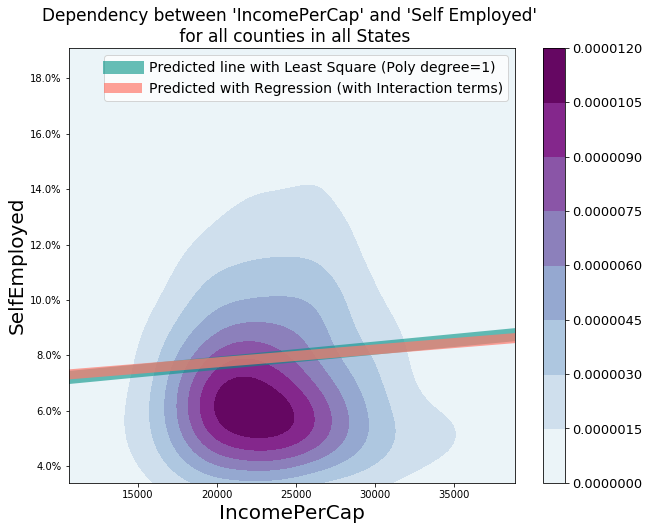

In [14]:
# Defining x and y from data points
x = df_county.IncomePerCap
y = df_county.SelfEmployed

# Plotting the data
plotting_line(x, y, X_s, ridge,
              title="Dependency between 'IncomePerCap' and 'Self Employed' \n for all counties in all States",)


**Discussion:**
    As we can see from the plots and coefficients, we can infer Counties that have *higher income per capita* tends to have *higher percentage* of Self Employed people. 
    
### Task 1: Answer to Section B) ###

In [15]:
from sklearn.linear_model import LinearRegression

def ridge_fitter(df, poly_n=2, num_F=None, corr_thr=0.45, slope=False, X_Y=True):
    # Creating matrix X_A as training set (we bring IncomePerCap to the first column for easier handling)
    X = df.iloc[:,np.r_[1:2, 35:36, 4:30, 31:35, 36:37]]
    Y = df.iloc[:,30:31]
    # Adding polynomial and interaction terms of features
    X = feature_processing(X.iloc[:,1:], poly_n=poly_n, var_thr=1.0e-6)
    # Select the most meaningful features
    X = feature_selection(X, Y, corr_thr=corr_thr, num_F=num_F)

    # Fitting Ridge regression with cross validation (n_fold=5)
    ridge = RidgeCV(alphas=[1e-4, 1e-3, 1e-2, 1e-1], cv=5, normalize=False, fit_intercept=True)
    #ridge = LinearRegression(normalize=False, fit_intercept=True)
    ridge.fit(X,Y)

    if slope:
        ridge = [ridge, ridge.coef_[0,0]]
    elif X_Y:
        ridge = [ridge, X, Y]
    return ridge

**Creating 'Set A' subset**

In [16]:
# Creating Set A
list_setA = ['Wisconsin', 'Tennessee', 'Minnesota']

# Filtering Data Frame based on list_filterA
set_A = df_county[df_county['State'].isin(list_setA)].reset_index(drop=True)

# Display 'Set A'
display(set_A.head())

,CensusId,State,County,TotalPop,Men,Women,Citizen,Employed,Hispanic,White,Black,Native,Asian,Pacific,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,Income,IncomeErr,IncomePerCap,IncomePerCapErr
0,27001,Minnesota,Aitkin,1.0,0.509123,0.490877,0.822464,0.405834,0.011,0.944,0.003,0.018,0.003,0.000,0.124,0.137,0.276,0.225,0.239,0.131,0.130,0.794,0.093,0.003,0.043,0.015,0.052,0.251,0.754,0.152,0.092,0.002,0.073,0.342252,0.007234,0.390107,0.023125
1,27003,Minnesota,Anoka,1.0,0.500602,0.499398,0.725387,0.534856,0.039,0.838,0.049,0.006,0.041,0.000,0.077,0.104,0.367,0.154,0.251,0.085,0.143,0.821,0.085,0.034,0.011,0.009,0.040,0.281,0.847,0.110,0.042,0.001,0.062,0.574089,0.007023,0.484375,0.006799
2,27005,Minnesota,Becker,1.0,0.500966,0.499034,0.744553,0.480687,0.018,0.868,0.005,0.070,0.005,0.000,0.128,0.170,0.327,0.175,0.202,0.137,0.159,0.778,0.108,0.004,0.029,0.015,0.066,0.228,0.743,0.164,0.090,0.003,0.035,0.421521,0.014005,0.402424,0.009497
3,27007,Minnesota,Beltrami,1.0,0.500506,0.499494,0.739182,0.452943,0.019,0.734,0.008,0.200,0.009,0.001,0.188,0.236,0.314,0.229,0.244,0.095,0.117,0.758,0.112,0.020,0.032,0.013,0.065,0.202,0.668,0.269,0.062,0.001,0.106,0.362543,0.016930,0.343354,0.015000
4,27009,Minnesota,Benton,1.0,0.497183,0.502817,0.742204,0.512583,0.019,0.927,0.023,0.003,0.011,0.000,0.149,0.187,0.295,0.174,0.213,0.115,0.203,0.819,0.091,0.010,0.015,0.016,0.049,0.233,0.829,0.112,0.057,0.002,0.067,0.422655,0.019676,0.386296,0.010000


In [17]:
# Creating matrix X_A as training set (we bring IncomePerCap to the first column for easier handling)
ridge_A, X_A, Y_A = ridge_fitter(set_A, poly_n=2, corr_thr=0.35, slope=False )

ml_slope = ridge_A.coef_[0,0]
ml_intercept = ridge_A.intercept_[0]
print('Fitting Score is {}'.format(ridge_A.score(X_A, Y_A)))
print('Coefficinet of IncomePerCap is {}'.format(ml_slope))
print('The intercept is {}'.format(ml_intercept))

Fitting Score is 0.9174194320555378
Coefficinet of IncomePerCap is 0.03109930077223875
The intercept is 0.23501797086366952


/usr/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Slope of prediction with least square method (poly degree=1) is -0.000114
Slope of prediction with Ridge regression is 0.000047


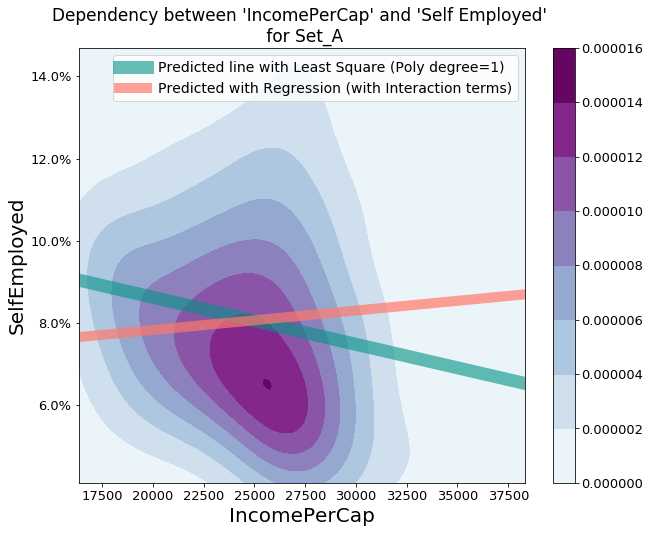

In [18]:
# Defining x and y for plotting
x = set_A.IncomePerCap
y = set_A.SelfEmployed

# Plotting the relation between IncomePerCap and SelfEmployed
plotting_line(x, y, X_A, ridge_A,
              title="Dependency between 'IncomePerCap' and 'Self Employed' \n for Set_A",)

**Discussion:**
    From the plot and coefficients, we can see that the dependency between SelfEmployed and IncomePerCap is stronger for set_A subset and despite the previous results, this relation is negative and shows counties with *higher* InomePerCap have *lower* SelfEmployed percentage.
  
### Task 1: Answer to Section C) ###

/usr/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


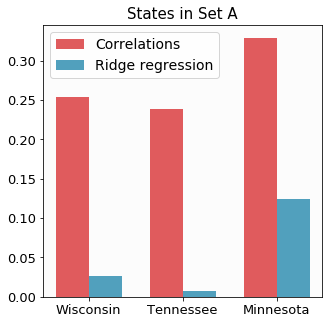

In [19]:
# Creating index
index = np.arange(len(list_setA))

# Calculating slope with Ridge regression (with n_fold=5 for cross-validation)
ridge_corrs = []
for i in range(len(list_setA)):
    df_i = df_county[df_county['State']==list_setA[i]]
    ridge, slope = ridge_fitter(df_i, poly_n=2 ,corr_thr=0.35, slope=True, X_Y=False)
    ridge_corrs.append(abs(slope))
    
bar_width = 0.35
corrs = (set_A[['IncomePerCap', 'State']].groupby('State')
         .corrwith(set_A.SelfEmployed).rename(columns={'IncomePerCap' : 'Corr_Coef'}).reset_index())

fig, ax = plt.subplots(figsize=(5,5))
ax.bar(index, corrs.Corr_Coef.abs(), width=bar_width, alpha=0.9, label='Correlations', color='#dd4a4c')
ax.bar(index+bar_width, ridge_corrs, width=bar_width, alpha=0.9, label='Ridge regression', color='#3f97b7' )

ax.set_facecolor((0.9, 0.9, 0.9, 0.1))
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(list_setA)
ax.legend(prop={'size': 14})
plt.title('States in Set A', fontsize=15)
plt.show()

**Discussion**

The results from correlation coefficients and coefficients from Linear Regression are at some degree different. But both of them shows that Minnesota has the highest dependency between *IncomePerCap* and *SelfEmployed* between other states.

### Task 1: Answer to Section D)
Now, we will look into the new subset of states ('New Jersey', 'Kansas', and 'Rhode Island').

In [20]:
list_setB = ['New Jersey', 'Kansas', 'Rhode Island']

# Filtering Data Frame based on list_filterA
set_B = df_county[df_county['State'].isin(list_setB)].reset_index(drop=True)

# Display 'Set A'
display(set_B.head())

,CensusId,State,County,TotalPop,Men,Women,Citizen,Employed,Hispanic,White,Black,Native,Asian,Pacific,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,Income,IncomeErr,IncomePerCap,IncomePerCapErr
0,20001,Kansas,Allen,1.0,0.492394,0.507606,0.764009,0.448207,0.031,0.912,0.017,0.002,0.005,0.001,0.180,0.225,0.296,0.173,0.198,0.092,0.241,0.798,0.105,0.007,0.044,0.014,0.032,0.163,0.728,0.178,0.091,0.002,0.070,0.313463,0.018857,0.315107,0.018155
1,20003,Kansas,Anderson,1.0,0.496581,0.503419,0.745441,0.455041,0.004,0.950,0.001,0.023,0.000,0.000,0.175,0.286,0.276,0.222,0.171,0.176,0.155,0.756,0.145,0.001,0.033,0.023,0.044,0.249,0.680,0.131,0.187,0.003,0.059,0.329648,0.029161,0.323567,0.019345
2,20005,Kansas,Atchison,1.0,0.479589,0.520411,0.759153,0.452053,0.028,0.882,0.041,0.004,0.003,0.001,0.192,0.263,0.328,0.171,0.217,0.101,0.183,0.736,0.109,0.001,0.074,0.010,0.069,0.208,0.801,0.135,0.060,0.004,0.073,0.353017,0.025030,0.330442,0.033994
3,20007,Kansas,Barber,1.0,0.502306,0.497694,0.770231,0.492662,0.034,0.930,0.003,0.003,0.005,0.000,0.109,0.156,0.338,0.145,0.197,0.157,0.162,0.829,0.077,0.001,0.029,0.009,0.056,0.135,0.703,0.173,0.120,0.005,0.031,0.419682,0.035722,0.429482,0.028933
4,20009,Kansas,Barton,1.0,0.485675,0.514325,0.718055,0.481769,0.140,0.826,0.013,0.001,0.002,0.000,0.159,0.226,0.299,0.181,0.243,0.144,0.133,0.818,0.109,0.001,0.030,0.010,0.031,0.170,0.760,0.160,0.077,0.002,0.068,0.356516,0.023669,0.371006,0.019451


In [21]:
# Creating matrix X_A as training set (we bring IncomePerCap to the first column for easier handling)
ridge_B, X_B, Y_B = ridge_fitter(set_B, poly_n=2, corr_thr=0.35, slope=False )

ml_slope = ridge_B.coef_[0,0]
ml_intercept = ridge_B.intercept_[0]
print('Fitting Score is {}'.format(ridge_B.score(X_B, Y_B)))
print('Coefficinet of IncomePerCap is {}'.format(ml_slope))
print('The intercept is {}'.format(ml_intercept))

Fitting Score is 0.9996606353515163
Coefficinet of IncomePerCap is 0.11353124185471652
The intercept is 0.8095998728109755


/usr/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Slope of prediction with least square method (poly degree=1) is -0.000174
Slope of prediction with Ridge regression is 0.000173


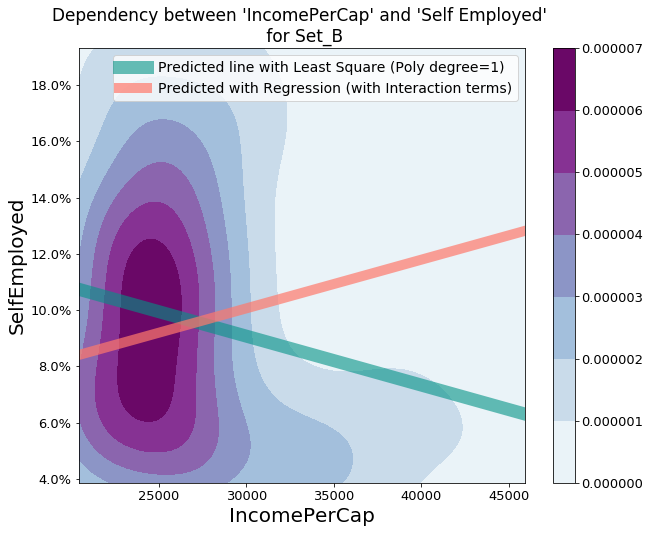

In [22]:
# Plotting the relation between IncomePerCap and SelfEmployed

# Defining x and y for plotting
x = set_B.IncomePerCap
y = set_B.SelfEmployed

plotting_line(x, y, X_B, ridge_B,
              title="Dependency between 'IncomePerCap' and 'Self Employed' \n for Set_B",)

The result is completely different from eachother...

/usr/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


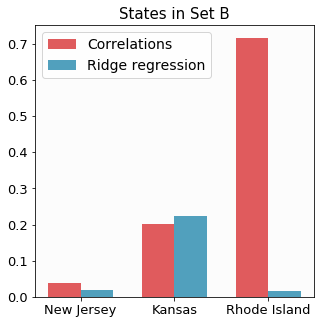

In [23]:
# Calculating 
index = np.arange(len(list_setB))

# Calculating slope with Ridge regression (with n_fold=5 for cross-validation)
ridge_corrs = []
for i in range(len(list_setB)):
    df_i = df_county[df_county['State']==list_setB[i]]
    ridge, slope = ridge_fitter(df_i, poly_n=2 ,corr_thr=0.35, slope=True)
    ridge_corrs.append(abs(slope))

    
bar_width = 0.35
corrs = (set_B[['IncomePerCap', 'State']].groupby('State')
         .corrwith(set_A.SelfEmployed).rename(columns={'IncomePerCap' : 'Corr_Coef'}).reset_index())

fig, ax = plt.subplots(figsize=(5,5))
ax.bar(index, corrs.Corr_Coef.abs(), width=bar_width, alpha=0.9, label='Correlations', color='#dd4a4c')
ax.bar(index+bar_width, ridge_corrs, width=bar_width, alpha=0.9, label='Ridge regression', color='#3f97b7' )

ax.set_facecolor((0.9, 0.9, 0.9, 0.1))
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(list_setB)
ax.legend(prop={'size': 14})
plt.title('States in Set B', fontsize=15)
plt.show()

## Task 2: All you need is love… And a dog!

Here we are going to build a classifier to predict whether an animal from an animal shelter will be adopted or not (aac_intakes_outcomes.csv, available at: https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes/version/1#aac_intakes_outcomes.csv). You will be working with the following features:

1. *animal_type:* Type of animal. May be one of 'cat', 'dog', 'bird', etc.
2. *intake_year:* Year of intake
3. *intake_condition:* The intake condition of the animal. Can be one of 'normal', 'injured', 'sick', etc.
4. *intake_number:* The intake number denoting the number of occurrences the animal has been brought into the shelter. Values higher than 1 indicate the animal has been taken into the shelter on more than one occasion.
5. *intake_type:* The type of intake, for example, 'stray', 'owner surrender', etc.
6. *sex_upon_intake:* The gender of the animal and if it has been spayed or neutered at the time of intake
7. *age_upon\_intake_(years):* The age of the animal upon intake represented in years
8. *time_in_shelter_days:* Numeric value denoting the number of days the animal remained at the shelter from intake to outcome.
9. *sex_upon_outcome:* The gender of the animal and if it has been spayed or neutered at time of outcome
10. *age_upon\_outcome_(years):* The age of the animal upon outcome represented in years
11. *outcome_type:* The outcome type. Can be one of ‘adopted’, ‘transferred’, etc.

**A)** Load the dataset and convert categorical features to a suitable numerical representation (use dummy-variable encoding). Split the data into a training set (80%) and a test set (20%). Pair each feature vector with the corresponding label, i.e., whether the outcome_type is adoption or not. Standardize the values of each feature in the data to have mean 0 and variance 1. The use of external libraries is not permitted in part A, except for numpy and pandas.

**B)** Train a logistic regression classifier on your training set. Logistic regression returns probabilities as predictions, so in order to arrive at a binary prediction, you need to put a threshold on the predicted probabilities. For the decision threshold of 0.5, present the performance of your classifier on the test set by displaying the confusion matrix. Based on the confusion matrix, manually calculate accuracy, precision, recall, and F1-score with respect to the positive and the negative class. Vary the value of the threshold in the range from 0 to 1 and visualize the value of accuracy, precision, recall, and F1-score (with respect to both classes) as a function of the threshold. The shelter has a limited capacity and has no other option but to put to sleep animals with a low probability of adoption. What metric (precision, recall, accuracy, or F1-score) and with respect to what class is the most relevant when choosing the threshold in this scenario, and why? Explain your reasoning.

**C)** Reduce the number of features by selecting the subset of the k best features. Use greedy backward selection to iteratively remove features. Evaluate performance and visualize the result using 5-fold cross-validation on the training set as a function of k, where k = 1, 5, 10, 15, 20, 25, 30. Choose the optimal k and justify your choice. Interpret the top-k features and their impact on the probability of adoption.

**D)** Train a random forest. Use 5-fold cross-validation on the training set to fine-tune the parameters of the classifier using a grid search on the number of estimators "n_estimators" and the max depth of the trees "max_depth". For the chosen parameters, estimate the performance of your classifier on the test set by presenting the confusion matrix, accuracy, precision, recall, and F1-score with respect to both classes and compare the performance with the performance of the logistic regression. Interpret the results.

You are allowed to use the scikit-learn library to implement your classifiers.

# Task 2: Implementation #
## Question A ##
### 1. Loading the data ###

As we are interested in building a classifier to predict whether an animal from an animal shelter will be adopted or not, we will only work with certain features. Therefore, when loading the data we only keep the columns containing information about these features. Indeed, loading all of the columns and droping them later on would be very inefficient. 
we will be working with the dataframe *data_animal* throughout this exercise. We display below the first rows of the dataframe and the type of the columns which will help us proceed with the cleaning.

In [24]:
# 1. We load the data by keeping only the usefull columns in memory

# We define the path to the csv file containing the data
ANIMAL_DATA = data_folder + "aac_intakes_outcomes.csv"

# We create a list of column names we will keep based on the instructions given for Task 2
usecols = ['animal_type','intake_year','intake_condition','intake_number','intake_type','sex_upon_intake',
           'age_upon_intake_(years)','time_in_shelter_days','sex_upon_outcome','age_upon_outcome_(years)','outcome_type']

# We use the read_csv() function with the usecols parameter
data_animal = pd.read_csv(ANIMAL_DATA, usecols=usecols)

# We display the dataframe and the types of the columns
print(data_animal.dtypes)
data_animal.head(5)

outcome_type                 object
sex_upon_outcome             object
age_upon_outcome_(years)    float64
animal_type                  object
intake_condition             object
intake_type                  object
sex_upon_intake              object
age_upon_intake_(years)     float64
intake_year                   int64
intake_number               float64
time_in_shelter_days        float64
dtype: object


,outcome_type,sex_upon_outcome,age_upon_outcome_(years),animal_type,intake_condition,intake_type,sex_upon_intake,age_upon_intake_(years),intake_year,intake_number,time_in_shelter_days
0,Return to Owner,Neutered Male,10.0,Dog,Normal,Stray,Neutered Male,10.0,2017,1.0,0.588194
1,Return to Owner,Neutered Male,7.0,Dog,Normal,Public Assist,Neutered Male,7.0,2014,2.0,1.259722
2,Return to Owner,Neutered Male,6.0,Dog,Normal,Public Assist,Neutered Male,6.0,2014,3.0,1.113889
3,Transfer,Neutered Male,10.0,Dog,Normal,Owner Surrender,Neutered Male,10.0,2014,1.0,4.970139
4,Return to Owner,Neutered Male,16.0,Dog,Injured,Public Assist,Neutered Male,16.0,2013,1.0,0.119444


### 2. Formating the data ###

By looking at the dataframe and the types of the columns, we can see that some columns contain data in the the wrong format. Here we change the format of the columns and display the resulting dataframe.

- float to int: The columns *age_upon_outcome_(years)*, *age_upon_intake_(years)* and *intake_number* should be coded in int instead of float because they contain finite numbers (years or counter).

- String to categorical: The columns *animal_type*, *sex_upon_outcome*, *intake_condition*, *intake_condition*, *intake_type*, *sex_upon_intake* contain strings that define different categories. Therefore we first change their format to category before splitting the colums to dummy variables. The column *outcome_type* should also be a categorical column, but we are actually interested in having only two categories: adopted or not adopted. Therefore we do the conversion of the type manually.

- Categorical to "dummy": The columns *animal_type*, *sex_upon_outcome*, *intake_condition*, *intake_condition*, *intake_type*, *sex_upon_intake* contain strings that define different categories. To convert the columns we use dummy variables that split each columns according to the different category. Each category will contain a values in {0,1}. Eg: the *animal_type* column contains 4 categories (Bird, Cat, Dog and Other), therefore the *animal_type* column gets split into (animal_type_Bird, animal_type_Cat, animal_type_Dog and animal_type_Other). The first row contains "Dog" therefore we get 0010.


In [25]:
# 2. We change the format of the columns of the data

# We change some of the columns into integer
integer_columns = ['intake_number','age_upon_outcome_(years)','age_upon_intake_(years)']
data_animal[integer_columns] = data_animal[integer_columns].apply(lambda x: x.astype('int'))

# We change some of the columns into categorical
categorical_columns = ['animal_type','sex_upon_outcome','intake_condition', 'intake_type', 'sex_upon_intake']
data_animal[categorical_columns] = data_animal[categorical_columns].apply(lambda x: x.astype('category'))

# We split the categorical columns into dummy variables and we store the names of the newly created columns
dummy_data = pd.get_dummies(data_animal[categorical_columns])
dummy_columns = dummy_data.columns.tolist()

# We add the created columns to the dataframe
data_animal = pd.concat([data_animal, dummy_data], axis=1, sort=False)

# We drop the categorical columns, as we have the information in dummy variables we don't need them anymore
data_animal = data_animal.drop(categorical_columns, axis=1)

# We reduce the number of categories in the *outcome_type* columns as we are only interested in knowing if the animal is adapted 
data_animal['outcome_type'] = data_animal['outcome_type'].map(lambda x: int(x == "Adoption"))

# We display the dataframe 
data_animal.head(5)

,outcome_type,age_upon_outcome_(years),age_upon_intake_(years),intake_year,intake_number,time_in_shelter_days,animal_type_Bird,animal_type_Cat,animal_type_Dog,animal_type_Other,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown,intake_condition_Aged,intake_condition_Feral,intake_condition_Injured,intake_condition_Normal,intake_condition_Nursing,intake_condition_Other,intake_condition_Pregnant,intake_condition_Sick,intake_type_Euthanasia Request,intake_type_Owner Surrender,intake_type_Public Assist,intake_type_Stray,intake_type_Wildlife,sex_upon_intake_Intact Female,sex_upon_intake_Intact Male,sex_upon_intake_Neutered Male,sex_upon_intake_Spayed Female,sex_upon_intake_Unknown
0,0,10,10,2017,1,0.588194,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1,0,7,7,2014,2,1.259722,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
2,0,6,6,2014,3,1.113889,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3,0,10,10,2014,1,4.970139,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,0,16,16,2013,1,0.119444,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


### 3. Spliting the data ###

In this section we will separae te data according the task 2.A instructions : 80% Train / 20% Test. From the size of the dataframe we will deduce the value of its 80% then shuffle the array before taking the samples. We need to proceed to the seperation before the standardization step because we want the train and test sets to be standardized independantly from each other. However, this steps follows the formating as there's no reason to do this independantly for each dataset.

In [26]:
# 4. We split the data into train and test

# We calculate the number of rows going into the train set and test (validation) set according to the proportion requested
eighty_perc = int(80 * len(data_animal) / 100.)
twenty_perc = len(data_animal) - eighty_perc

# We shuffle the data with a seed set to 12 so that if we run the code again we get same results 
# (8) Everyday I am shuffleing (8)
np.random.seed(12)
data_animal = pd.DataFrame(np.random.permutation(data_animal), columns=data_animal.columns.values)

# We keep the first eigthy_perc elements for train and the last twenty_perc for test
train_set = data_animal.head(eighty_perc).copy()
test_set = data_animal.tail(twenty_perc).copy()

### 4. Standardizing the data ###

We want to standardize the values of each feature in the data to have mean=0 and variance=1. This is already the case for the dummy variables, but we still need to standardize the columns: *age_upon_outcome_(years)*, *age_upon_intake_(years)*, *intake_year*, *intake_number* and *time_in_shelter_days*. For each column we calculate the mean and the variance, then we substract the mean and divide by the variance. We need to do this process for both train and test sets, therefore we define a new function *standardize()*. We display the resulting columns after standardizing.


In [27]:
# 4. We standardizing the data

# We create a array of all the columns we will standardized using the previous array 'integer_columns'
standardized_columns = integer_columns
standardized_columns.extend(['intake_year', 'time_in_shelter_days'])

def standardize(data, columns):

    # We calculate the mean and variance of each columns and reshape the arrays to matrices
    size = data[columns].shape
    mean = np.tile(np.mean(data[columns]), (size[0], 1))
    variance = np.tile(np.std(data[columns]), (size[0], 1))
    
    # We substract the mean of each columns and we divide them by their standard deviation
    data[columns] = (data[columns] - mean) / variance
    
# TRAIN SET 
standardize(train_set,standardized_columns)

# TEST SET
standardize(test_set,standardized_columns)

In [28]:
# We display the resulting standardized columns for the train set
train_set[standardized_columns].head()

,intake_number,age_upon_outcome_(years),age_upon_intake_(years),intake_year,time_in_shelter_days
0,-0.27653,1.001868,1.014499,-1.102155,-0.373372
1,-0.27653,4.373485,4.405082,1.202672,-0.400500
2,-0.27653,-0.346779,-0.341734,0.434396,-0.380150
3,-0.27653,-0.683940,-0.680792,0.434396,-0.300760
4,-0.27653,0.327545,0.336383,0.434396,-0.302969


### 5. Normalizing the data (dummy variables) ###

For the dummy variable we can't standardize the values but we can normalize them by computing the frequency of 1 in each column. We display the resulting columns after normalizing.

In [29]:
# 5. We normalize the data

def normalize(data, columns):
    # We compute the size of the portion of the dataframe corresponding to the specified columns
    size = data[columns].shape
    # We divide each values of a specific column by the number of 1 in that column
    data[columns] = data[columns] / np.tile(data[columns].sum(),(size[0], 1))
    
# TRAIN SET 
normalize(train_set,dummy_columns)

# TEST SET
normalize(test_set,dummy_columns)

In [30]:
# We display the resulting standardized columns for the train set
train_set[dummy_columns].head()

,animal_type_Bird,animal_type_Cat,animal_type_Dog,animal_type_Other,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown,intake_condition_Aged,intake_condition_Feral,intake_condition_Injured,intake_condition_Normal,intake_condition_Nursing,intake_condition_Other,intake_condition_Pregnant,intake_condition_Sick,intake_type_Euthanasia Request,intake_type_Owner Surrender,intake_type_Public Assist,intake_type_Stray,intake_type_Wildlife,sex_upon_intake_Intact Female,sex_upon_intake_Intact Male,sex_upon_intake_Neutered Male,sex_upon_intake_Spayed Female,sex_upon_intake_Unknown
0,0.0,0.000000,0.000028,0.0,0.0,0.000000,0.000000,0.000049,0.0,0.0,0.0,0.000000,0.000018,0.0,0.0,0.0,0.0,0.0,0.000083,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000112,0.0
1,0.0,0.000042,0.000000,0.0,0.0,0.000000,0.000044,0.000000,0.0,0.0,0.0,0.000312,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000022,0.0,0.000000,0.000000,0.000098,0.000000,0.0
2,0.0,0.000042,0.000000,0.0,0.0,0.000127,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000018,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000022,0.0,0.000000,0.000049,0.000000,0.000000,0.0
3,0.0,0.000000,0.000028,0.0,0.0,0.000000,0.000000,0.000049,0.0,0.0,0.0,0.000000,0.000018,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000022,0.0,0.000053,0.000000,0.000000,0.000000,0.0
4,0.0,0.000000,0.000028,0.0,0.0,0.000000,0.000044,0.000000,0.0,0.0,0.0,0.000000,0.000018,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000022,0.0,0.000000,0.000049,0.000000,0.000000,0.0


## Question 2 ##
### 1. Training the classifier ###

In this section we will train the actual classifier using the sklearn library on the training set. Our aim is to determine if an animal is going to be adopted, therefore the first column of the datframe *outcome_type* holds the labels (y). First, we first split the datasets into labels (*y_train*,*y_test*) and features (*X_train*,*X_test*).

In [31]:
# 1. First separates between datas (X) and labels (y) for both train and test sets

# TRAIN SET

# Using .values allows to get only the values from the datafram (without their column name and indexes)
y_train = train_set['outcome_type'].values
# Get everything except the labels
X_train = train_set.loc[:, train_set.columns != 'outcome_type'].values 

# TEST SET

# Same procedure as for the train set
y_test = test_set['outcome_type'].values 
X_test = test_set.loc[:, test_set.columns != 'outcome_type'].values

# Put values inside linear regression training function
model = sk_lm.LogisticRegression(solver='lbfgs').fit(X_train, y_train)

### 2. Making predictions ###

Now that we trained the model on the training set we can apply the model to the test set and evaluate its the performance. As we may have to do this multiple times in this exercice, we define two functions: 
- One to make the prediction: for each animal (row) we get the the probability of adoption (between 0 and 1)
- One to compute the labels out of the prediction: we use a threshold probability (ex: 0.5) to binarize the results

In [32]:
# Takes as input the features X and a the model
# Returns a array of probabilities of adaption s.t. probability[0] = probability(X[0] = adopted)
def adoption_prediction(X, model):
    prediction = model.predict_proba(X) 
    # predict proba return array like [[p(e1 = 0),p(e1 = 1)], [p(e2 = 0), p(e2 = 1)]]
    # Therefore we return only the last column which correspond to P(elem = 1) -> p(adopted)
    return prediction[:,-1] 

# Takes an array of probabilities and a threshold value
# Returns an array where which contains: 0 if pb < threshold / 1 if pb > threshold
def adoption_labels(probability, threshold= 0.5):
    return (probability > threshold).astype(int)  

In [33]:
# 2. Making predictions
threshold = 0.5
# We get the probabilities
prediction = adoption_prediction(X_test, model)
# We get the labels with a threshold
predicted_labels = adoption_labels(prediction, threshold)

### 3. Land of confusion: computing the confusion matrix  ###

Once we have the *predicted_labels* we can compute the confusion matrix by comparing them to the real labels *y_test*. This way we can have an estimate of the True Positive, False Positive, True Negative, and False Negative values. We display the counts of each category in a daframe as well as the confusion matrix built with it.

In [34]:
# Takes the predicted labels and the real labels
# Returns an array containing the counts
def label_counts(predicted_labels, real_labels):
    
    # First filter: we compute a mask which indicates the TP and TN (the inverse mask will give the FP and FN)
    equal_mask = np.equal(real_labels, predicted_labels)

    # Second level of filtering: we determine how many of the equal values are TP and TN by looking at the sum of the labels
    TP = np.sum((real_labels[equal_mask] + predicted_labels[equal_mask]) == 2)
    TN = np.sum((real_labels[equal_mask] + predicted_labels[equal_mask]) == 0)

    # Second filter: we determine how many of the non equal values are FP and FN by looking at the difference of the labels
    FN = np.sum((real_labels[np.invert(equal_mask)] - predicted_labels[np.invert(equal_mask)]) == 1)
    FP = np.sum((real_labels[np.invert(equal_mask)] - predicted_labels[np.invert(equal_mask)]) == -1)

    return pd.DataFrame(np.matrix([[TP,FP,TN,FN]]), index = ['counts'], columns = ['TP','FP','TN','FN'])
    
def confusion_matrix_adopted(counts):
    # We construct a pandas dataframe out of the counts for the TP, FP, FN and TN
    return pd.DataFrame(np.matrix([[counts['TP'][0], counts['FP'][0]], [counts['FN'][0], counts['TN'][0]]]),
                        index = pd.MultiIndex.from_tuples([('Prediction','Adopted'), ('Prediction','Not Adopted')]),
                        columns = pd.MultiIndex.from_tuples([('Reality','Adopted'), ('Reality','Not Adopted')]))

def confusion_matrix_not_adopted(counts):
    # We construct a pandas dataframe out of the counts for the TP, FP, FN and TN
    return pd.DataFrame(np.matrix([[counts['TN'][0], counts['FN'][0]], [counts['FP'][0], counts['TP'][0]]]),
                        index = pd.MultiIndex.from_tuples([('Prediction','Not Adopted'), ('Prediction','Adopted')]),
                        columns = pd.MultiIndex.from_tuples([('Reality','Not Adopted'), ('Reality','Adopted')]))
#real_labels = np.array([0,1,0,1])
#predicted_labels = np.array([0,0,1,1]) 
#cm = confusion_matrix(predicted_labels, y_test) [1,1 ; 1,1]
# Just to compare
# tn, fp, fn, tp = sk_m.confusion_matrix(y_test, predicted_labels).ravel()

In [35]:
# Building the confusion matrices
counts = label_counts(predicted_labels, y_test)
cm_adopted = confusion_matrix_adopted(counts)
cm_not_adopted = confusion_matrix_not_adopted(counts)

print('Counting the labels:')
display(counts)
print('Confusion matrix computed with respect to the adopted class:')
display(cm_adopted)
print('Confusion matrix computed with respect to the not adopted class:')
display(cm_not_adopted)

Counting the labels:


,TP,FP,TN,FN
counts,2582,689,8511,4153


Confusion matrix computed with respect to the adopted class:


Reality            
                       Adopted Not Adopted
Prediction Adopted        2582         689
           Not Adopted    4153        8511

Confusion matrix computed with respect to the not adopted class:


Reality        
                       Not Adopted Adopted
Prediction Not Adopted        8511    4153
           Adopted             689    2582

Depending if we compute the confusion matrix with respect to the class *adopted* or the class *not apdopted* we might get different results when computing the performance metrics. To get the values for the not adopted class we have to inverse both the TP/TN and the FP/FN values in the original confusion matrix for the *adopted* class.

### 4. Computing performance metrics ###

Now that we have the confusion matrix, we can compute the Precision, Recall, Accuracy and F1-score that will help us determine the performance of the model. As we will have to this again in this exercise, we create a function that computes these metrics based on the confusion matrix.

- Precision: $ P =  \dfrac{TP}{TP + FP} $
- Recall: $ R =  \dfrac{TP}{TP + FN} $
- Accuracy: $ A =  \dfrac{TP + TN}{TP + TN + FP + FN} $
- F1-Score: $ F1 = 2 * \dfrac{P * R}{P + R} $

In [36]:
# Takes a pandas dataframe containing the confusion matrix
# Returns a pandas dataframe containing the computed
def compute_metrics(confusion_matrix, colname):
    
    # We get the counts from the confusion matrix
    TP = confusion_matrix.iloc[0][0]
    TN = confusion_matrix.iloc[1][1]
    FP = confusion_matrix.iloc[1][0]
    FN = confusion_matrix.iloc[0][1]
    
    # We compute the metrics using the formulas
    P = TP / (TP + FP)
    R = TP / (TP + FN)
    A = (TP + TN) / (TP + TN + FP + FN)
    F1 = 2 * (P * R) / (P + R)
    
    # We return the metrics in an array for easy display
    return pd.DataFrame([round(P,5), round(R,5), round(A,5), round(F1,5)], index = ['Precision', 'Recall', 'Accuracy', 'F1-Score'], columns = [colname])

In [37]:
# Computing the metrics with respect to the class "adopted"
metrics_adopted = compute_metrics(cm_adopted, 'adopted ' + str(threshold))

# Computing the metrics with respect to the class "non adopted"
metrics_not_adopted = compute_metrics(cm_not_adopted, 'not adopted ' + str(threshold))

metrics_adopted.join(metrics_not_adopted)

,adopted 0.5,not adopted 0.5
Precision,0.38337,0.92511
Recall,0.78936,0.67206
Accuracy,0.69614,0.69614
F1-Score,0.51609,0.77854


As we can see the result are quite similar but it looks like the computing with respect to the *adopted* class seems to score better relatively to the recall and F1-score. We will invastigate the results further by changing testing a few threshold.

### 5. Treshold variation ###

In this section we will see how the variation of the threshold in the interval [0,1] influences the metrics. To get the results we will use a helper function which will compute the metrics for each threshold. To see how the results are affected we will explore two representation of the results:
1. Dataframe display : With a relatively low number of intervals all display in their own dataframe
2. Graphical display : With four different graphs (one per metrics) those one can holds many more instance of threshold


In [38]:
# Takes the featurex X, the predictions y, the model and the thresholds to be tested
# Returns an array of adopted metrics, an array of non adopted metrics
def compute_multiple_metrics(X, y, model, thresholds):

    # We define an empty dataframe which will contain the results
    metrics = pd.DataFrame()
    for th in thresholds: 
        # We get the probabilities
        prediction = adoption_prediction(X, model)
        
        # We get the labels with a threshold
        predicted_labels = adoption_labels(prediction, th)
        
        # We count the number of TP, TN, FP, FN
        lbl_counts = label_counts(predicted_labels, y)
        
        # We compute the confusion matrices with respect to the adopted class and not adopted class
        cm_adopted = confusion_matrix_adopted(lbl_counts)
        cm_not_adopted = confusion_matrix_not_adopted(lbl_counts)
        
        # Computing confusion matrix with respect to the class adopted and not adopted
        metrics_adopted = compute_metrics(cm_adopted, 'adopted ' + str(round(th, 4)))
        metrics_not_adopted = compute_metrics(cm_not_adopted, 'not adopted ' + str(round(th, 4)))

        # We join the metrics tables for adopted and not adopted classes and we apend them to the resulting table
        metrics = metrics.join(metrics_adopted.join(metrics_not_adopted), how='right')
        
    return metrics

### 6.1. The dataframe approach ###

To not get overwhelmed by displaying too much dataframe we chose to try 4 different threshold values: 0.2, 0.4, 0.6 and 0.8.
The values 0 and 1 for threshold have been ignored since it does not make sense to have a classifier outputing the same thing over and over.

In [39]:
# 6.1. The dataframe approach

# We define the threshold array with the values to try out
threshold = [0.2, 0.4, 0.6, 0.8]

# We use the function defined above to get the resulting table with the metrics for both classes and different thresholds
compute_multiple_metrics(X_test, y_test, model, threshold)

,adopted 0.2,not adopted 0.2,adopted 0.4,not adopted 0.4,adopted 0.6,not adopted 0.6,adopted 0.8,not adopted 0.8
Precision,0.97996,0.09424,0.65212,0.77913,0.28537,0.95793,0.14699,0.98424
Recall,0.44197,0.86527,0.68369,0.75365,0.83239,0.64678,0.87225,0.61182
Accuracy,0.46859,0.46859,0.72545,0.72545,0.67367,0.67367,0.63037,0.63037
F1-Score,0.60919,0.16997,0.66753,0.76618,0.42503,0.77219,0.25159,0.75458


### 6. Analysis of the results ###

- Precision: The smaller the threshold the bigger is the precision for the adopted classe and the other way around for the class not adopted.
- Recall: The recall follows the inverse trend of the precision.
- Accuracy: The accuracy is the same for both classes as it's calculated the same way with respect to both classes.
- F1-Score: We can see that this metrics is peaking around 0.4 for both classes.

### 6.2. The graphs approach ###

In the next cell we will plot the 4 different metrics in graphs (on metrics with respect to both class per graph). This type of reprentation will allow us to get much more intervals without hurting the representation. As this time the aim is to construct graphs, we compute the metrics for a larger number of thresholds from 0.05 to 0.99 with a step size of 0.01. 
Note: We do not try values under 0.5 as we get divisions by 0 in the calculation of the metrics because of the float approximation.

In [40]:
# 6.1. The dataframe approach

# We define the threshold array with the values to try out (rounded to 4 digits)
threshold = np.round(np.arange(0.05,0.99,0.01),4)

# We use the function defined above to get the resulting table with the metrics for both classes and different thresholds
all_metrics = compute_multiple_metrics(X_test, y_test, model, threshold)

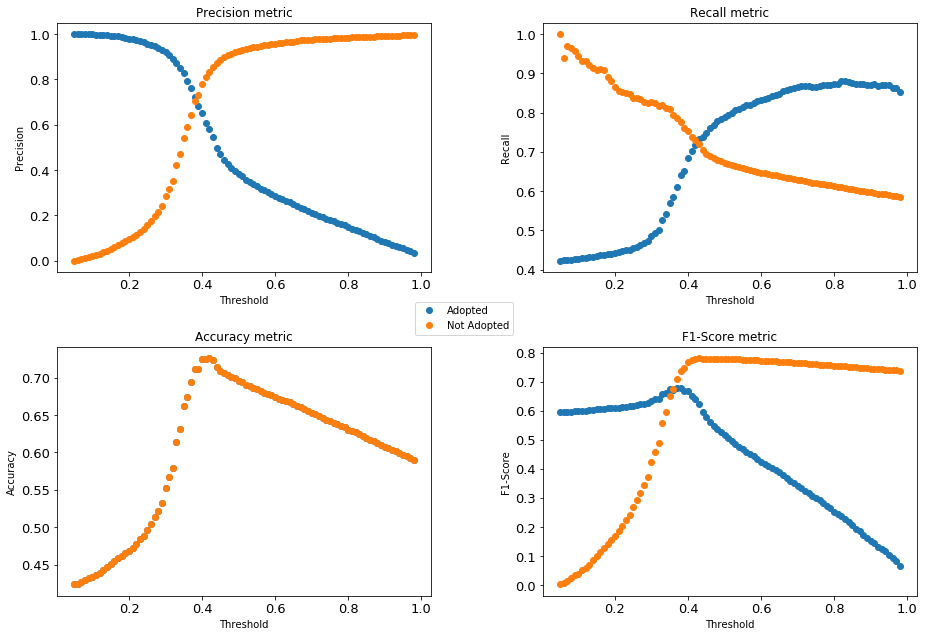

In [41]:
# Generating the 4 graphs

# Generate a 2x2 subplot array
fig, ax = plt.subplots(nrows=2, ncols=2)

# Bigger display
plt.subplots_adjust(left=0.01, bottom=0.01, right=2., top=2., wspace=.3, hspace=.3)

# Set titles
ax[0][0].set_title("Precision metric")
ax[0][1].set_title("Recall metric")
ax[1][0].set_title("Accuracy metric")
ax[1][1].set_title("F1-Score metric")

# Plot precisions
ax[0][0].plot(threshold, all_metrics.loc['Precision'][0::2],'o', label="Adopted")
ax[0][0].plot(threshold, all_metrics.loc['Precision'][1::2],'o', label="Not Adopted")
ax[0][0].set_xlabel("Threshold")
ax[0][0].set_ylabel("Precision")

# Plot recall
ax[0][1].plot(threshold, all_metrics.loc['Recall'][0::2],'o', label='_nolegend_')
ax[0][1].plot(threshold, all_metrics.loc['Recall'][1::2],'o', label='_nolegend_')
ax[0][1].set_xlabel("Threshold")
ax[0][1].set_ylabel("Recall")

# Plot accuracy
ax[1][0].plot(threshold, all_metrics.loc['Accuracy'][1::2],'o', label='_nolegend_')
ax[1][0].plot(threshold, all_metrics.loc['Accuracy'][0::2], 'o', label='_nolegend_')
ax[1][0].set_xlabel("Threshold")
ax[1][0].set_ylabel("Accuracy")

# Plot f1
ax[1][1].plot(threshold, all_metrics.loc['F1-Score'][0::2], 'o', label='_nolegend_')
ax[1][1].plot(threshold, all_metrics.loc['F1-Score'][1::2], 'o', label='_nolegend_')
ax[1][1].set_xlabel("Threshold")
ax[1][1].set_ylabel("F1-Score")

# Global legend
fig.legend(loc='center')

# Show must go on
plt.show()

### 6.3 Discussion of the results ###

We can infer from these graphs the same conlusions as earlier, but we also get more information. One thing we notice immediately is that around 0.4, the curves for precision, recall and F1-Score seem to intersect. The accuracy being the same for both classes, the curves are overlaping and there's a peak around this threshold. 

As the clinic wants minimize the number of animals in the shelter they have to choose which of them they will put to sleep. The main convern here is the space but this procedure raises an ethical question. We don't want to put to sleep animals that could have been adopted and this concern ends up being more important than the space occupancy. 

From this interpretation of the problem we understand that we want to minimize in priority the FN for the adopted class (or the FP for the not adopted class) to make sure we don't put to sleep animals that could have been adopted. As a second priority we want to minimize the FP for the adopted class (or the FN for the not adopted class) to make sure that most of the remaining animals will be adopted. 

Therefore the metric we have to look at is the Recall. We can't just minimize the recall because then we would loose in accuracy. Plus we would like both classes to give similar results, therefore we should look at the intersection for the recall around 0.4. As explained earlier, around this value the other metrics are also optimum.

### 7. Choosing the best threshold ###

Now that we know which metric we want to look at to determine choose the threshold, we will compute the best threshold value.
With this optimum threshold we can get the metrics and the confusion matrices for both classes and analyze the results.


In [42]:
# 7. Choosing the best threshold

# We get the values for the selected metric and the selected class
R_adopted = all_metrics.loc['Recall'][0::2]
R_not_adopted = all_metrics.loc['Recall'][1::2]

# We substract the arrays and find the index of the intersection
intersection = abs(R_adopted.values - R_not_adopted.values)
intersection_idx = np.where(intersection == min(intersection))[0][0]

# We find the threshold with the computed index (the thresholds are the same for both classes)
th_adopted = threshold[intersection_idx]
th_not_adopted = th_adopted

# We compute the metrics for the threshold
best_thresholds = compute_multiple_metrics(X_test, y_test, model, [th_adopted])


In [43]:
# Computing the confusion matrices with the thresholds

# For the adopted class
predicted_labels = adoption_labels(prediction, th_adopted )
counts = label_counts(predicted_labels, y_test)
cm_adopted = confusion_matrix_adopted(counts)

# For the not adopted class
predicted_labels = adoption_labels(prediction, th_not_adopted )
counts = label_counts(predicted_labels, y_test)
cm_not_adopted = confusion_matrix_not_adopted(counts)

# We display the resulting confusions matrices
print('Confusion matrix for the Adopted class (threshold = ' + str(round(th_adopted, 4)) + ')')
display(cm_adopted)

print('Confusion matrix for the Not Adopted class (threshold = ' + str(round(th_not_adopted, 4)) + ')')
display(cm_not_adopted)

Confusion matrix for the Adopted class (threshold = 0.42)


Reality            
                       Adopted Not Adopted
Prediction Adopted        3904        1530
           Not Adopted    2831        7670

Confusion matrix for the Not Adopted class (threshold = 0.42)


Reality        
                       Not Adopted Adopted
Prediction Not Adopted        7670    2831
           Adopted            1530    3904

In [58]:
# Computing the metrics with respect to the class "adopted"
best_th_metrics_adopted = compute_metrics(cm_adopted,'adopted th = ' + str(round(th_adopted, 4)))

# Computing the metrics with respect to the class "non adopted"
best_th_metrics_not_adopted = compute_metrics(cm_not_adopted, 'not adopted th = ' + str(round(th_adopted, 4)) )

best_th_metrics_adopted.join(best_th_metrics_not_adopted)

,adopted th = 0.42,not adopted th = 0.42
Precision,0.57966,0.83370
Recall,0.71844,0.73041
Accuracy,0.72633,0.72633
F1-Score,0.64163,0.77864


### 8. Analysis of the results ###

We can see in the confusion matrix that the classifier is doing really well at identifying non adopted animal. However the number of animal miss-classified "Not adopted" animal might be a concern.

In a real life setup we should look at what is the policy of the animal shelter. Shall the number of places be maximised this would be a relatively good classifier (low number of "Not adopted" animal are kept) but if the ethic is the concern (not killing the lowest amount of "Adoptable" animal) we might look again at the threshold and chose lower value with a better precision toward the "Adopted class" with the risk of keeping more "Not adopted" animal and maybe run out of space. 

# Question 3

After the analysis made in Question 2, we know the class, the metrics and the threshold we need to use to predict the adoption of the animals in the shelter. The purpose of this question is to now investigate if we can delete some features and if we can either keep the same value for the metric or get an even better value. Moreover, deleating some feature will decrease the ammount of memory needed and the computation time. For this we will implement a greedy backward selection to iteratively remove features.

We will base our analysis on the class *adopted*, the metric *Accuracy* and the treshold *0.42*.

### 1. Leave-one-out Cross Validation ###

The first step to implement the greedy backward selection is to define a function to make a 5-fold cross-validation. For this we used the functions we defined in the course Machine Learning, adjusting them to the purpose of this exercice. There are 3 main functions: 
- split_data_k_indices: computes the indices to divide the training set into k_fold = 5 parts
- cross_validation: this function computes the prediction and the metrics for one iteration of leave-one-out cross validation
- cross_validation_loop: this function computes k_fold = 5 iterations of leave-one-out cross validation. This function returns the average metric over all the iterations.


In [44]:
# 1. Leave-one-out Cross Validation functions

def split_data_k_indices(y, k_fold, seed):
    
    nb_rows = y.shape[0]
    
    # Number of parts in which we want to divide the data k_fold 
    # As the number of rows might not be divisible by k_fold we might left out some rows (nb_rows % k_fold in total)
    interval = int(nb_rows / k_fold)
    
    # We shuffle the rows
    np.random.seed(seed)
    indices = np.random.permutation(nb_rows)
    
    # We extract indices for each kth part of the data
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    
    # We return the array of indices corresponding to each kth part of the data
    return np.array(k_indices)


def cross_validation(y, X, k_indices, k, threshold, choosen_metric, choosen_class):

    # We determine the train indices by leaving out the kth indices
    train_indices=np.delete(k_indices, k, axis=0).ravel()
    
    # We get the training set with the training indices (k_fold-1 parts)
    xtrain=X[train_indices]
    ytrain=y[train_indices]
    
    # We get the testing set with the testing indices (1 part)
    xtest=X[k_indices[k]]; 
    ytest=y[k_indices[k]]; 
    
    # We train the model on the training set
    model = sk_lm.LogisticRegression(solver='lbfgs').fit(xtrain, ytrain)
    
    # We apply the model to the testing set and we compute the resulting metrics
    metrics = compute_multiple_metrics(xtest, ytest, model, threshold)
    
    # We return the wanted metric for the choosen class
    return metrics.loc[choosen_metric][choosen_class]
    

def cross_validation_loop(y, X, k_fold, k_indices, seed, threshold, choosen_metric, choosen_class):
    
    # We define an empty dataframe which will contain the metric computations 
    metric_evolution = []
    
    # For each kth part in k_fold we do the cross validation and add the resulting metric to the array
    for k in range(k_fold):
        metric_evolution.append(cross_validation(y, X, k_indices, k, threshold, choosen_metric, choosen_class))
        
    # We return an average of the metric over all the iterations
    return round(np.mean(metric_evolution),6)

In [45]:
# 2. Testing the functions

# We define a seed so that the results can be generated again
seed = 12
k_fold = 5

# We compute the indices to split the data
k_indices = split_data_k_indices(y_train, k_fold, seed)

# We choose the threshold, the class and the metric 
# Note: 1 for not adopted and 0 for adopted
threshold = [th_adopted]
choosen_metric = 'Accuracy'
choosen_class = 0

# Testing the cross_validation_loop function
cross_validation_loop(y_train, X_train, k_fold, k_indices, seed, threshold, choosen_metric, choosen_class)

0.720578

### 2. Greedy backward selection ###

Now that the cross-validation is implemented we can implement the greedy backward selection algorithm. For this we define a function that iteratively removes features from the data X until there are k of them remaning. 

Each time we decrease the features by one, we try all of the permutation possible for the column to be deleted (indexed from 0 to k-1) and we look at the impact of the deleted column to the metric. Then we search for the column index corresponding to the column that afects the least the metric. Therefore we delete the column corresponding to the maximum of the metric. 

The function defined actually iteratively removes 31 features (original number of features - 1) and stores the results when the number of features is equal to k in the k_values = [1, 5, 10, 15, 20, 25, 30]. 

The function gives back an array of metrics for each k in k_values.

In [46]:
# 1. Greedy Backward Selection function

def greedy_backward_selection(y, X, k_values, k_fold, seed, threshold, choosen_metric, choosen_class):
   
    # Number of features in the original data
    nb_features = X.shape[1]
    
    # Copies of the data
    final_X = X
    new_X = X
    
    # Arrays in which we will store the results
    metrics = []
    metric_evolution = []
    
    # We loop over the range of features -1
    for i in range(nb_features-1): 
        
        # We loop over all of the indices remaining in the data
        for f in range(nb_features - i):

            # We delete the fth column from the data
            new_X = np.delete(new_X, f, 1)
            
            # We compute the metric
            metrics.append(cross_validation_loop(y, new_X, k_fold, k_indices, seed, threshold, choosen_metric, choosen_class))
            
            # We start over for the next iteration
            new_X = final_X
        
        # We determine the index of the column which affects the metric the least (maximal value)
        feature_idx = np.where(metrics == max(metrics))[0][0]
        
        # We delete the column from the data using its index
        final_X = np.delete(final_X, feature_idx, 1)
        
        # We update the data for the next iteration
        new_X = final_X
        
        # If the number of the remaining features in the data corresponds to one of the value in k_values we store the results
        if final_X.shape[1] in k_values:
            metric_evolution.append(cross_validation_loop(y, final_X, k_fold, k_indices, seed, threshold, choosen_metric, choosen_class))
            
        # We empty the metrics array for the next iteration
        metrics = []
    
    # We return an array containing the results for each value in k_values
    return metric_evolution
    

In [47]:
# 2. Testing the Greedy Backward Selection function
k_values = np.arange(1,X_train.shape[1],1) 
metric_evolution = greedy_backward_selection(y_train, X_train, k_values, k_fold, seed, threshold, choosen_metric, choosen_class)

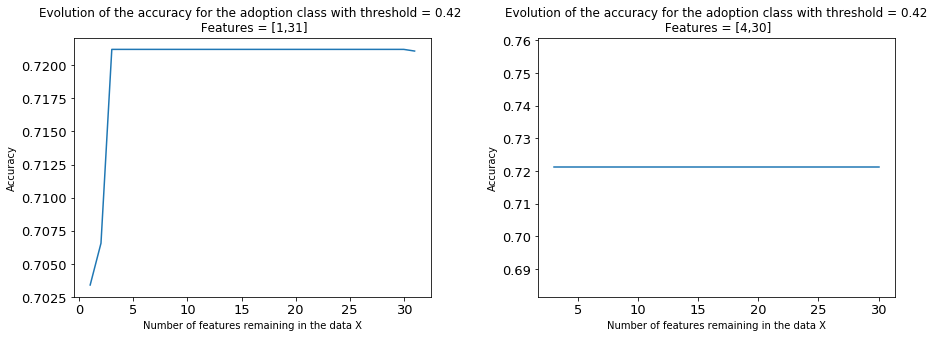

In [48]:
# 3. Graph of the results

# We reverse the values to have them in the order of k_values
metrics = metric_evolution[::-1]

# Generate a 1x2 subplot array
fig, ax = plt.subplots(nrows=1, ncols=2)

# Bigger display
plt.subplots_adjust(left=0.1, bottom=0.1, right=2., top=1., wspace=.3, hspace=.2)

# Set titles
ax[0].set_title('Evolution of the accuracy for the adoption class with threshold = ' + str(round(th_not_adopted, 4)) \
                + ' \n Features = [1,31]')
ax[1].set_title('Evolution of the accuracy for the adoption class with threshold = ' + str(round(th_not_adopted, 4)) \
                + '\n Features = [4,30]')

# Features = [1,31]
ax[0].plot(k_values, metrics)
ax[0].set_xlabel('Number of features remaining in the data X')
ax[0].set_ylabel('Accuracy')

# Features = [4,30]
ax[1].plot(k_values[2:30], metrics[2:30])
ax[1].set_xlabel('Number of features remaining in the data X')
ax[1].set_ylabel('Accuracy')

# Show must go on
plt.show()

### 3. Analysis of the results ###

The accuracy seems to remain constant through the deletion of columns until there are less than 4 columns remaining. We notice a slight improvement of the accuracy when we go from 32 to 31 columns but this is very small (~10^(-4)). Out of the k_values = [1,5,10,15,20,25,30] we were suggested to try, it is best to reduce the number of features to a number of k=5 (even if we could go as low as 4 as seen in the graph). If we go pass this number, we loose (0.7200 - 0.7025) = 0.0175 = 1.75% of accuracy. This isn't a lot but it's considerable enough to not go that low as we already reduced the data from k=32 features to k=5 features, saving 27 columns from the memory, which represents more than 80% of the original number of features.

## Question D ##

In this part we will train and optimize a random forest and two hyperparameter using a grid search and cross validation

### 1. Hyperparameter range ###

In this part we will define the range of the parameters (n_iterators and max_depth) for the grid search

In [61]:
estimators = np.arange(11) * 20 + 10
depth = np.arange(11) * 5 + 10
print("n_estimators values : ")
print(estimators)
print("depth values : ")
print(depth)

n_estimators values : 
[ 10  30  50  70  90 110 130 150 170 190 210]
depth values : 
[10 15 20 25 30 35 40 45 50 55 60]


### 2. Train and optimize ###

In this section of the notebook we will train and optimize the random forest classifier.

To do so we will first define two helper function. One to get the corresponding fold of the cross validation

The second for which will do the grid search by iteration over all the different parameter.

In the last question we consider the accuracy as the evaluation metric of the classifier. To be coherant we will do the same for the random forest.

In [62]:
# Return the nTH of k folds and the rest
# n goes from 1 to k
def get_nth_fold(data_x, data_y, n, k=5):
    fold_size = int(len(data_x)/k)# Should be the same for both data_x and data_y
    small_slice = (n-1) * fold_size
    big_slice = n * fold_size
    
    return (data_x[small_slice : big_slice], data_y[small_slice : big_slice]),(np.concatenate([data_x[:small_slice], data_x[big_slice:]]),np.concatenate([data_y[:small_slice], data_y[big_slice:]]))

# Will optimize a random forest classifier with a rid search for a list of estimators and depth
# Using a k-fold validation 
def optimize_random_forest(X_tr, y_tr, estimators, depth, folds):
    # Array that will store the result for each hyperparameter instance
    results = []
    
    # Start of grid search
    for est in estimators:
        for dep in depth:
            # Create model with hyperparameters est and dep
            clf = sk_ens.RandomForestClassifier(n_estimators=est, max_depth=dep)
            # Array that will hold the individual error for each folds
            accur = []
            
            for fold in range(folds):
                # Separate the train set with train and validation for cross validation
                test, train = get_nth_fold(X_tr, y_tr, fold + 1, folds)
                # Fit the model
                clf.fit(train[0], train[1])
                # Since we used accuracy on adopted to measure the performance in question C
                # we will do the same for the random forest                
                counts = label_counts(clf.predict(test[0]), test[1] )
                cm_adopted = confusion_matrix_adopted(counts)
                accuracy = compute_metrics(cm_adopted, 'a')['a'][2] # get accuracy
                accur.append(accuracy)
                
            # Get the mean of accuracy for all folds and put it in the results
            results.append((est, dep, np.mean(accur) ) )
    
    return max(results, key = lambda t: t[2]) # Return the params for max accuracy
           

In [63]:
best = optimize_random_forest(X_train, y_train, estimators, depth, 5)

print("Best value for random forest grid search : ")
print("n_estimators : " + str(best[0]))
print("depth : " + str(best[1]))
print("Accuracy : " + str(best[2]))


Best value for random forest grid search : 
n_estimators : 130
depth : 15
Accuracy : 0.8532680000000001


### 3. Analyse on the test set ###

In this part we will train the random forest with the whole train set and verify its performances by computing the confusion matrix given after the passage of the test set.

In [64]:
clf = sk_ens.RandomForestClassifier(n_estimators=best[0], max_depth=best[1])

clf.fit(X_train, y_train)

rdm_counts = label_counts(clf.predict(X_test), y_test)
rdm_cm_adopted = confusion_matrix_adopted(rdm_counts)
rdm_cm_not_adopted = confusion_matrix_not_adopted(rdm_counts)

# Computing the metrics with respect to the class "adopted"
rdm_metrics_adopted = compute_metrics(rdm_cm_adopted, "est = " + str(best[0]) + ", depth = " + str(best[1]) + ' adopted' )

# Computing the metrics with respect to the class "non adopted"
rdm_metrics_not_adopted = compute_metrics(rdm_cm_not_adopted, 'not adopted')

rdm_metrics_adopted.join(metrics_not_adopted)

,"est = 130, depth = 15 adopted",not adopted 0.5
Precision,0.88597,0.92511
Recall,0.79496,0.67206
Accuracy,0.85522,0.69614
F1-Score,0.83800,0.77854


In [65]:
display(rdm_cm_adopted)
display(rdm_cm_not_adopted)

Reality            
                       Adopted Not Adopted
Prediction Adopted        5967        1539
           Not Adopted     768        7661

Reality        
                       Not Adopted Adopted
Prediction Not Adopted        7661     768
           Adopted            1539    5967

### 4. Discussion ###

This classifier does a wunderful job regarding the concerns raised in Q2 part 8. The number of false positive and false negative is very low. Even better the number of "adoptable" animal classified as "not adoptable" is the lowest value of all. Which mean we have a very small number of unecessary death. This highlights that both on practical point of view (space taken) and an ethical point of view (not kill adoptable animal) the random forest is doing a better job than the linear regression.

On a purely numerical approach the random forest manage to score better on all metrics at the same time which decreases the number of tradeoff on that we had to do on the logistic classifier. 